In [29]:
#this gonna get cray
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures

with open ("data/train_df_20180425-1926.pkl", "rb") as picklefile:
    train_df = pickle.load(picklefile)

plt.style.use("fivethirtyeight")
%matplotlib inline

### Make column masks to quickly grab `target` and `features` from a `DataFrame`

In [30]:
targets = ["dnf_rate", "sqrt_dnf_rate", "log_dnf_rate"]
features = (["gender:ladies","days_since_season_start","olympics"]+
            [dummy for dummy in train_df.columns if ("event:" in dummy or "region:" in dummy)]
           )
#features

### Playing with target transformations

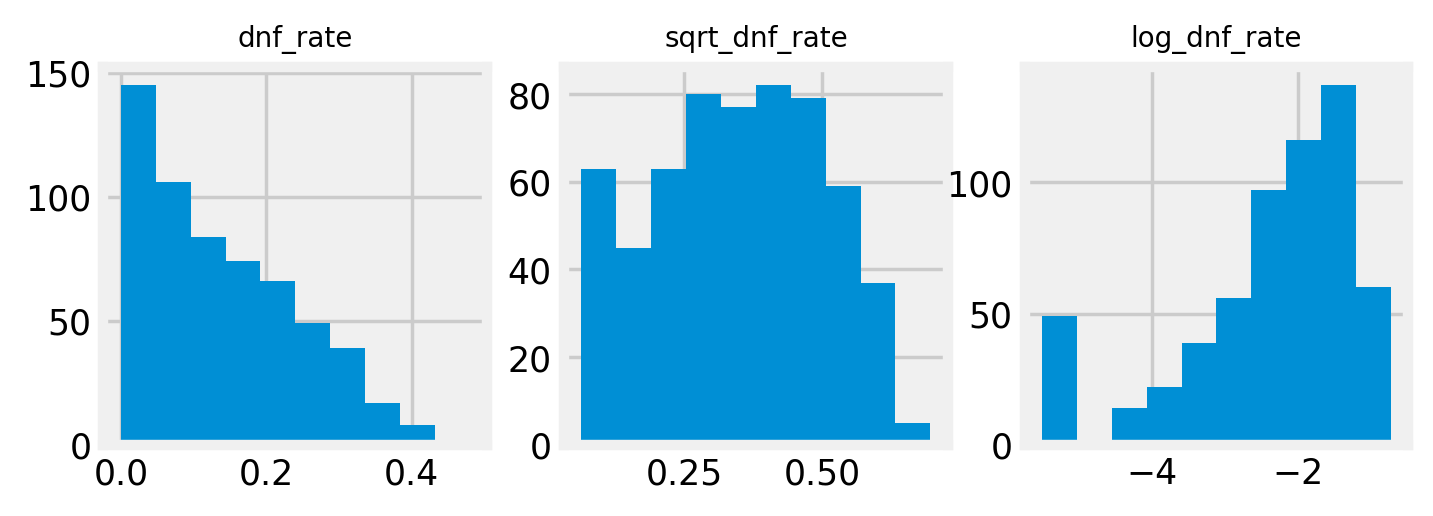

In [31]:
plt.figure(dpi=250,figsize=(6,2))
for i, t in enumerate(targets):
    plt.subplot(1,3,i+1)
    plt.hist(train_df[t])
    plt.title(t, size=8)

Despite the more uniform appearance of the `sqrt_dnf_rate`, it performed consistently worse than the default 
`dnf_rate`. The log transformation also did not help.

In [32]:
target = "dnf_rate"

## Preprocessing data

```python
rand_state = np.random.randint(2048)
y_trains=[]
y_tests=[]
for i, t in enumerate(targets):
    X_train, X_test, y_train, y_test = \
        train_test_split(train_df[features], train_df[t], test_size=0.2, random_state=rand_state)
    y_trains.append(y_train)
    y_tests.append(y_test)
```
Turns out none of that matters, because `dnf_rate` is the most predictable.

## Polynomial features -> StandardScalar -> Lasso:
These are the coefficients of one run, sorted by absolute value:
```
 1. ('event:Slalom^1', 0.04139540044301016)
 2. ('event:Downhill^1', -0.03886310728099469)
 3. ('gender:ladies^1xevent:Slalom^1', -0.01231170117047865)
 4. ('days_since_season_start^2', -0.011981244297940648)
 5. ('event:Slalom^1xregion:SE_ALPS^1', 0.011671326921970085)
 6. ('event:Giant Slalom^1', 0.010595905490916678)
 7. ('event:Super G^1', -0.009924742966351584)
 8. ('event:Slalom^2', 0.0057614445534406)
 9. ('gender:ladies^1xdays_since_season_start^1', -0.005332106804633901)
10. ('region:CAN^1', -0.003909911911563925)
11. ('event:Giant Slalom^2', 0.0031164459254945077)
12. ('event:Giant Slalom^1xregion:ITA^1', 0.0026340308878495334)
13. ('event:Super G^1xregion:KOR^1', -0.00223899398694845)
14. ('days_since_season_start^1xregion:SE_ALPS^1', 0.0021775668778881135)
15. ('event:Downhill^1xregion:GER^1', 0.0018927794796225565)
16. ('event:Super G^1xregion:BUL^1', -0.0018438489763193144)
17. ('olympics^1xregion:NEUTRAL^1', 0.001725458665476746)
18. ('region:CAN^2', -0.0015826683386807128)
19. ('event:Super G^1xregion:ITA^1', -0.00144808294346535)
20. ('days_since_season_start^1xregion:FRA^1', -0.000760165266449663)
21. ('olympics^1xregion:KOR^1', -0.0007355745136791676)
22. ('event:Giant Slalom^1xregion:GER^1', -0.0006827442087098016)
23. ('gender:ladies^1xregion:CAN^1', -0.0006411909596604941)
24. ('gender:ladies^1xolympics^1', 0.00019852758608558332)
25. ('event:Giant Slalom^1xregion:SE_ALPS^1', 9.561096346954774e-05)
26. ('event:Super G^1xregion:CAN^1', -7.857644340798337e-05)
27. ('', 0.0)
28. ('gender:ladies^1', -0.0)
29. ('days_since_season_start^1', -0.0)
30. ('olympics^1', 0.0)
```
 - (16) Rare situations, like Super G in Bulgaria, are considered highly indicative. Significant overfitting.
     `model.score(*test_tuple)` returned 0.67, though, which was better than most straight linear tests.
 - `event:*` and `region:*` are boolean. Squaring them is meaningless.
 - (4) `days_since_season_start^2` being so highly rated is interesting, so that will be added to the dataframe.
 - `gender:ladies`, which normally lowers the rate, may be split into (4) `event:Slalom` and (9) `days_since_season_start`. Other interactions are weak and not repicable.
 - but so can `region:SE_ALPS`, the most strongly predictive region. (19) and (5)

```python
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)
```

In [68]:
def mult_columns(df, head_a, head_b=None):
    if head_b == None:
        head_b = head_a
    return [a*b for a,b in zip(df[head_a],df[head_b])]

In [69]:
def polymerize_df(df):
    df["days^2_since_season_start"] = mult_columns(df, "days_since_season_start")
    df["days^3_since_season_start"] = mult_columns(df, "days_since_season_start", "days^2_since_season_start")
    #df["gender:ladies*event:Slalom"] = mult_columns(df, "gender:ladies","event:Slalom")
    #df["gender:ladies*days_since"]   = mult_columns(df, "gender:ladies","days_since_season_start")
    #df["region:SE_ALPS*event:Slalom"] = mult_columns(df,"region:SE_ALPS","event:Slalom")
    #df["region:SE_ALPS*days_since"]   = mult_columns(df, "region:SE_ALPS","days_since_season_start")


In [70]:
polymerize_df(train_df)
features = features + ["days^2_since_season_start",
                       "days^3_since_season_start",
                       #"gender:ladies*event:Slalom",
                       #"gender:ladies*days_since",
                       #"region:SE_ALPS*event:Slalom",
                       #"region:SE_ALPS*days_since"
                      ]

In [71]:
X_train, X_test, y_train, y_test = \
     train_test_split(train_df[features], train_df[target], test_size=0.2) #random_state=42)

In [72]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

### Regularization

In [73]:
def run_model(model, Xtrain, Xtest, t):
    model.fit(Xtrain, y_trains[t])
    print("Score: ",model.score(Xtest, y_tests[t]))
    plot_residuals(model, Xtest, t)
    
def plot_residuals(model, xtest, t):
    y_hat = model.predict(xtest)
    error = (y_hat - y_tests[t])
    plt.plot(y_hat, error, "o")

**Mean Absolute Error** because I think there are going to be significant features I haven't been able to include, and I don't want to waste accuracy chasing outliers due to bad weather or a poor course setup.
**Lasso** because there are a large number of features that likely have no effect.

In [74]:
model=Lasso(max_iter=50000000)
parameters = {"alpha": [x*1e-4 for x in range(5,18)], "fit_intercept":[True, False]}
grid = GridSearchCV(model,parameters, cv=5, scoring="neg_mean_absolute_error", n_jobs=3, return_train_score=True)
grid.fit(X_train_scaled, y_train);

In [75]:
grid.best_params_

{'alpha': 0.0007, 'fit_intercept': True}

In [90]:
lcv0 = LassoCV(max_iter=20000000,alphas=[0.0006],fit_intercept=True, cv=5)
lcv0.fit(X_train_scaled,y_train)
lcv0.score(X_test_scaled,y_test)

0.646460626462017

In [77]:
grid.cv_results_

{'mean_fit_time': array([0.00217214, 0.00120091, 0.0013813 , 0.00103621, 0.00113139,
        0.00102539, 0.00109906, 0.00101991, 0.00087929, 0.00095472,
        0.00088568, 0.00088944, 0.00079947, 0.00090084, 0.00084267,
        0.00086484, 0.00075459, 0.00082693, 0.00076146, 0.00084062,
        0.00071416, 0.00081291, 0.00073524, 0.00069923, 0.00070019,
        0.00069566]),
 'mean_score_time': array([0.00040135, 0.0002049 , 0.00020142, 0.00027857, 0.00019555,
        0.00019865, 0.00020247, 0.00021648, 0.00021048, 0.00021539,
        0.00021381, 0.000244  , 0.00020075, 0.00019813, 0.00022383,
        0.0001977 , 0.00019641, 0.00019965, 0.0002121 , 0.00020447,
        0.00019827, 0.00020046, 0.00020247, 0.00021091, 0.00019994,
        0.00019717]),
 'mean_test_score': array([-0.05335182, -0.14725338, -0.05335003, -0.14720048, -0.0533482 ,
        -0.14715537, -0.05336263, -0.14711258, -0.05337981, -0.14706922,
        -0.05340756, -0.14703735, -0.05344511, -0.14700635, -0.05348454,
  

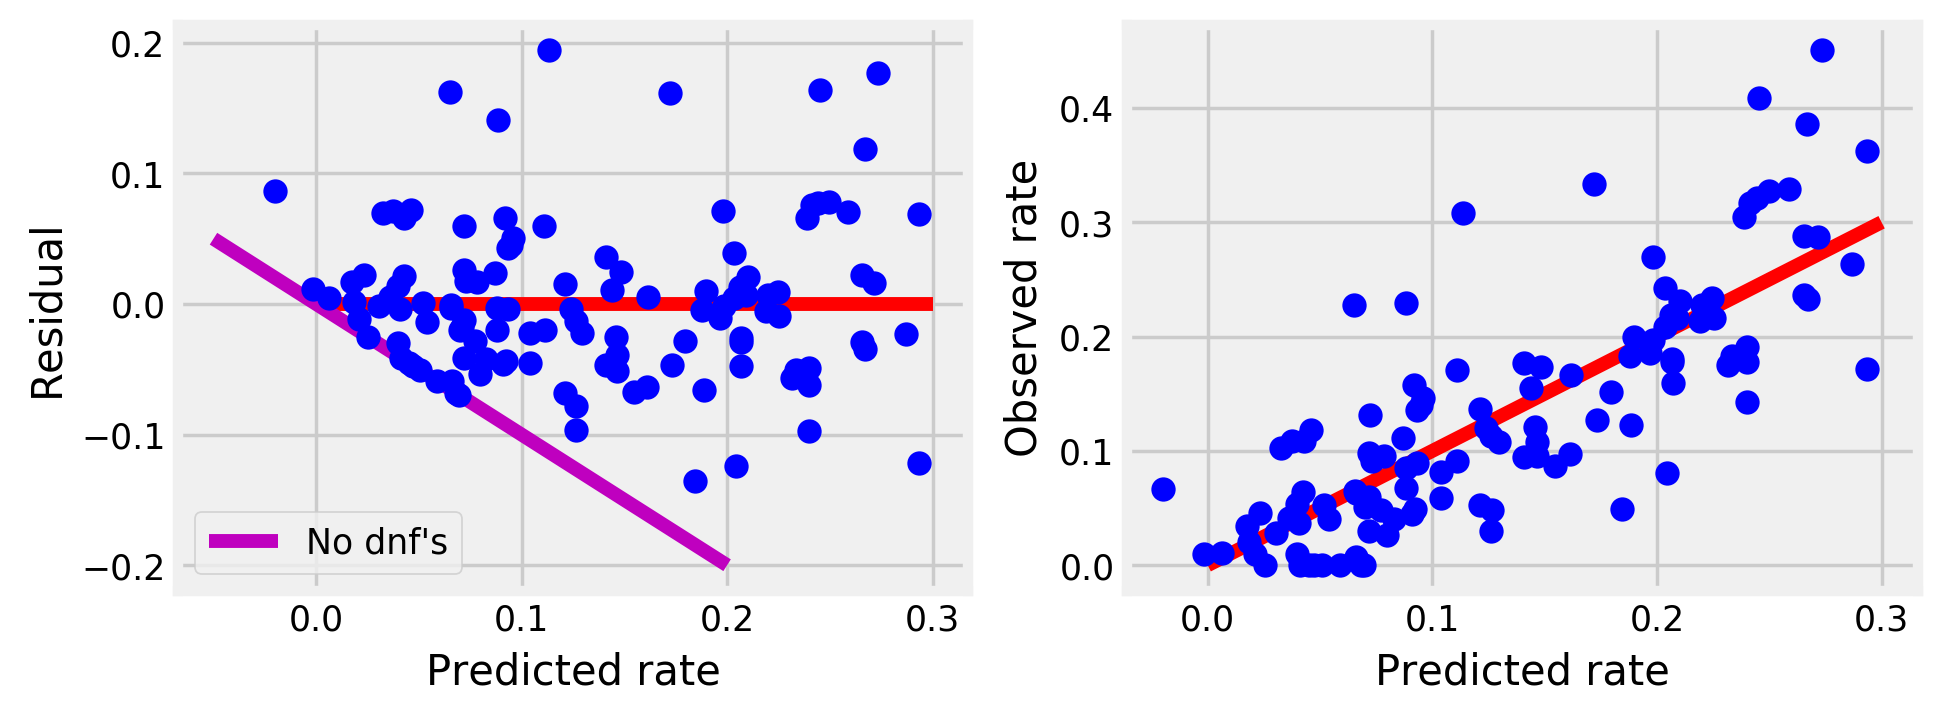

In [78]:
best_lasso = grid.best_estimator_
lasso_pred = best_lasso.predict(X_test_scaled)
resid = [true-pred for true, pred in zip(y_test, lasso_pred)]

ValueError: x and y must have same first dimension, but have shapes (118,) and (147,)

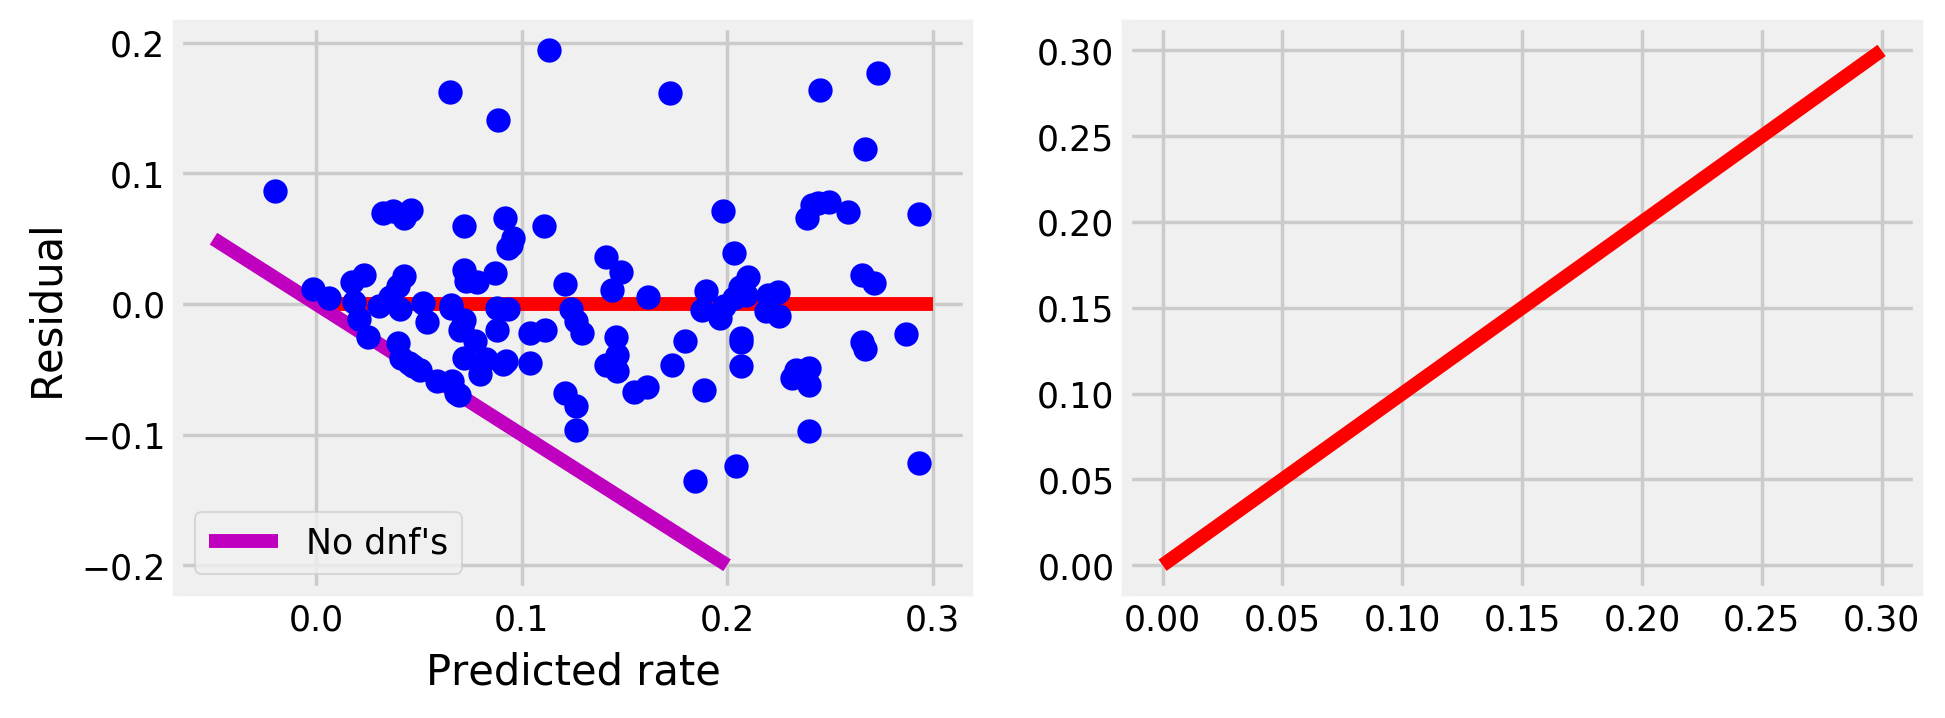

In [102]:
plt.figure(dpi=250,figsize=(8,3))

plt.subplot(1,2,1)
plt.plot([0,.3],[0,0],"r")
plt.plot([-0.05,0.2],[0.05,-.2],"m", label="No dnf's")
plt.plot(lasso_pred,resid,"ob")
plt.legend(loc="lower left")
plt.xlabel("Predicted rate")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.plot([0,.3],[0,.3],"r")
plt.plot(lasso_pred,y_test, "ob")
plt.xlabel("Predicted rate")
plt.ylabel("Observed rate");

In [96]:
best_lasso.fit(X_train_scaled,y_train)
best_lasso.score(X_train_scaled,y_train)

0.6521596443914253

In [97]:
best_lasso.score(X_test_scaled,y_test)

0.6461457076241794

In [79]:
from scipy.stats import normaltest

In [80]:
normaltest(resid)

NormaltestResult(statistic=16.18697156330039, pvalue=0.0003055229126572798)

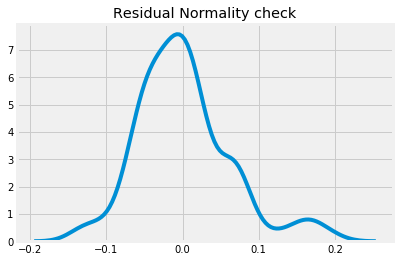

In [81]:
plt.title("Residual Normality check")
sns.kdeplot(resid);

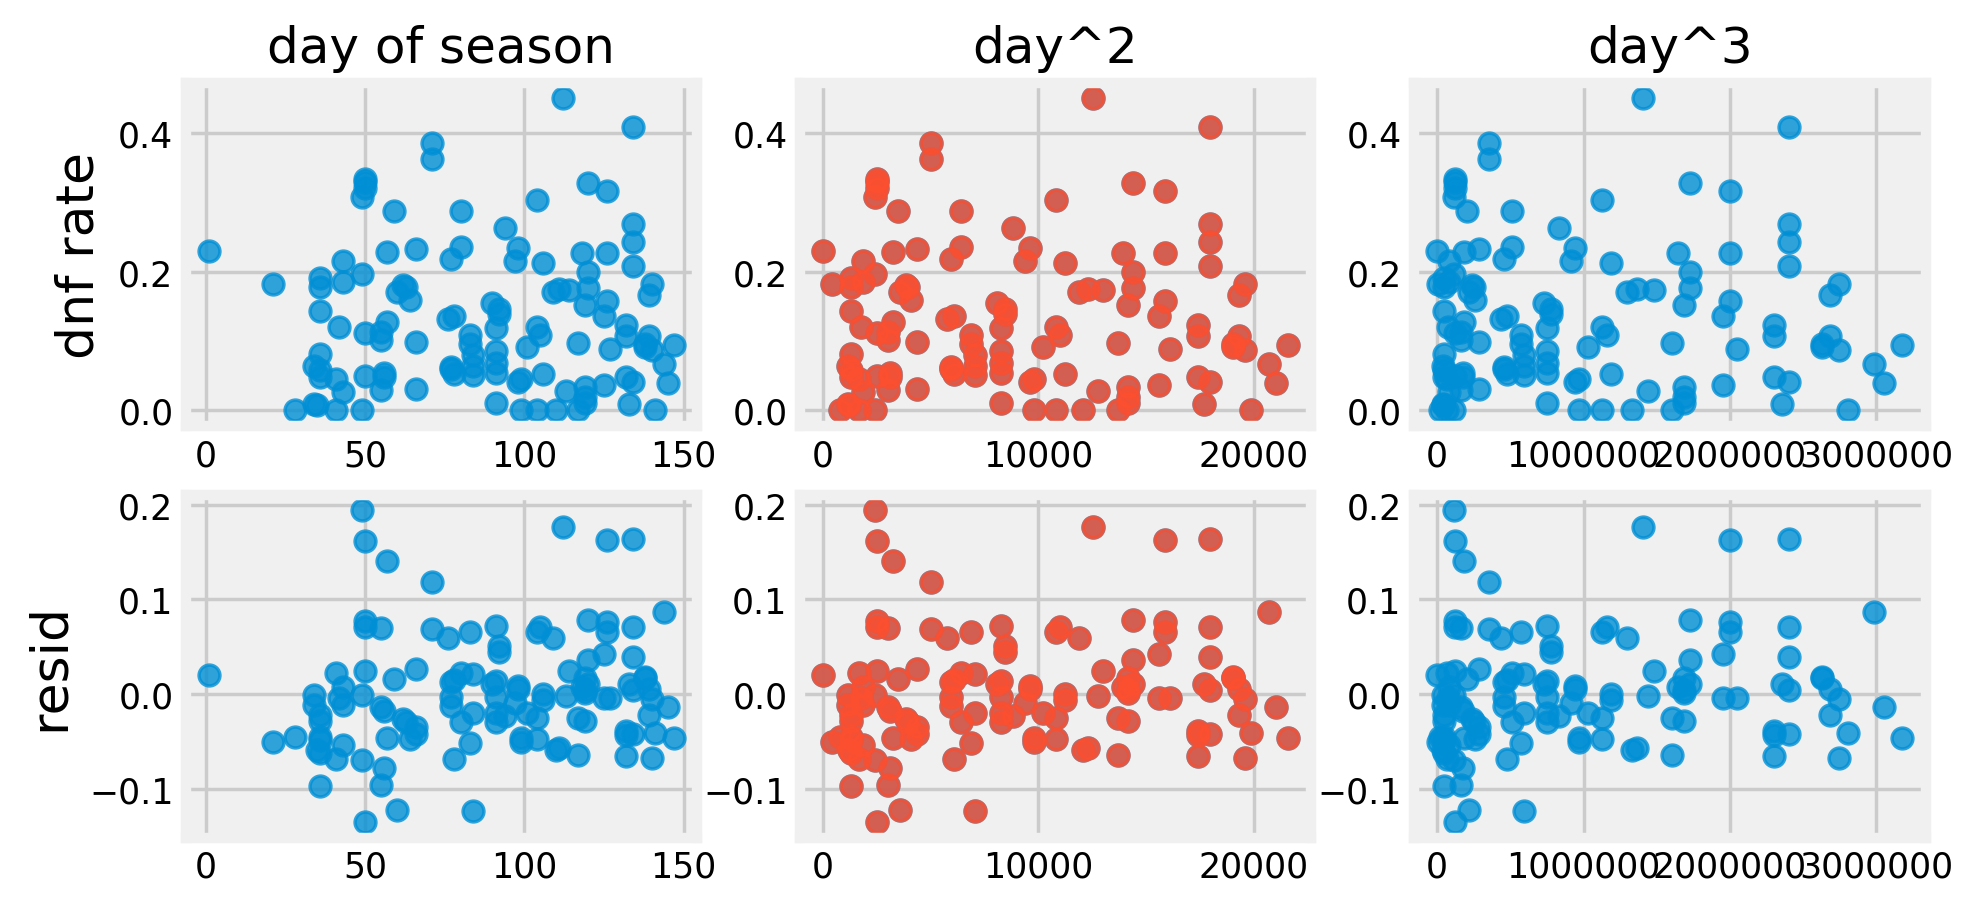

In [86]:
plt.figure(dpi=250, figsize=(8,4))
plt.tight_layout()

plt.subplot(2,3,1)
plt.ylabel("dnf rate",size=15)
plt.plot(X_test["days_since_season_start"],y_test,"o", alpha=0.8)
plt.title("day of season")

plt.subplot(2,3,2)
plt.plot(X_test["days^2_since_season_start"], y_test, "o", alpha=0.8)
plt.title("day^2")

plt.subplot(2,3,3)
plt.plot(X_test["days^3_since_season_start"], y_test, "o", alpha=0.8)
plt.title("day^3")


plt.subplot(2,3,4)
plt.ylabel("resid",size=15)
plt.plot(X_test["days_since_season_start"],resid,"o", alpha=0.8)

plt.subplot(2,3,5)
plt.plot(X_test["days^2_since_season_start"], resid, "o", alpha=0.8)

plt.subplot(2,3,6)
plt.plot(X_test["days^3_since_season_start"], resid, "o", alpha=0.8)

In [107]:
with open("data/final_model-TIME.pkl", "wb") as picklefile:
    pickle.dump(best_lasso, picklefile)

# Final modelling

In [108]:
with open("data/test_df_20180425-1926.pkl", "rb") as picklefile:
    test_df = pickle.load(picklefile)
with open("data/final_model-1121.pkl", "rb") as picklefile:
    best_lasso = pickle.load(picklefile)
polymerize_df(test_df)

In [104]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

In [105]:
ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)
X_test_scaled = ssX.transform(X_test)

Training score: 0.6535609431433091
Testing_score: 0.5634016043633949


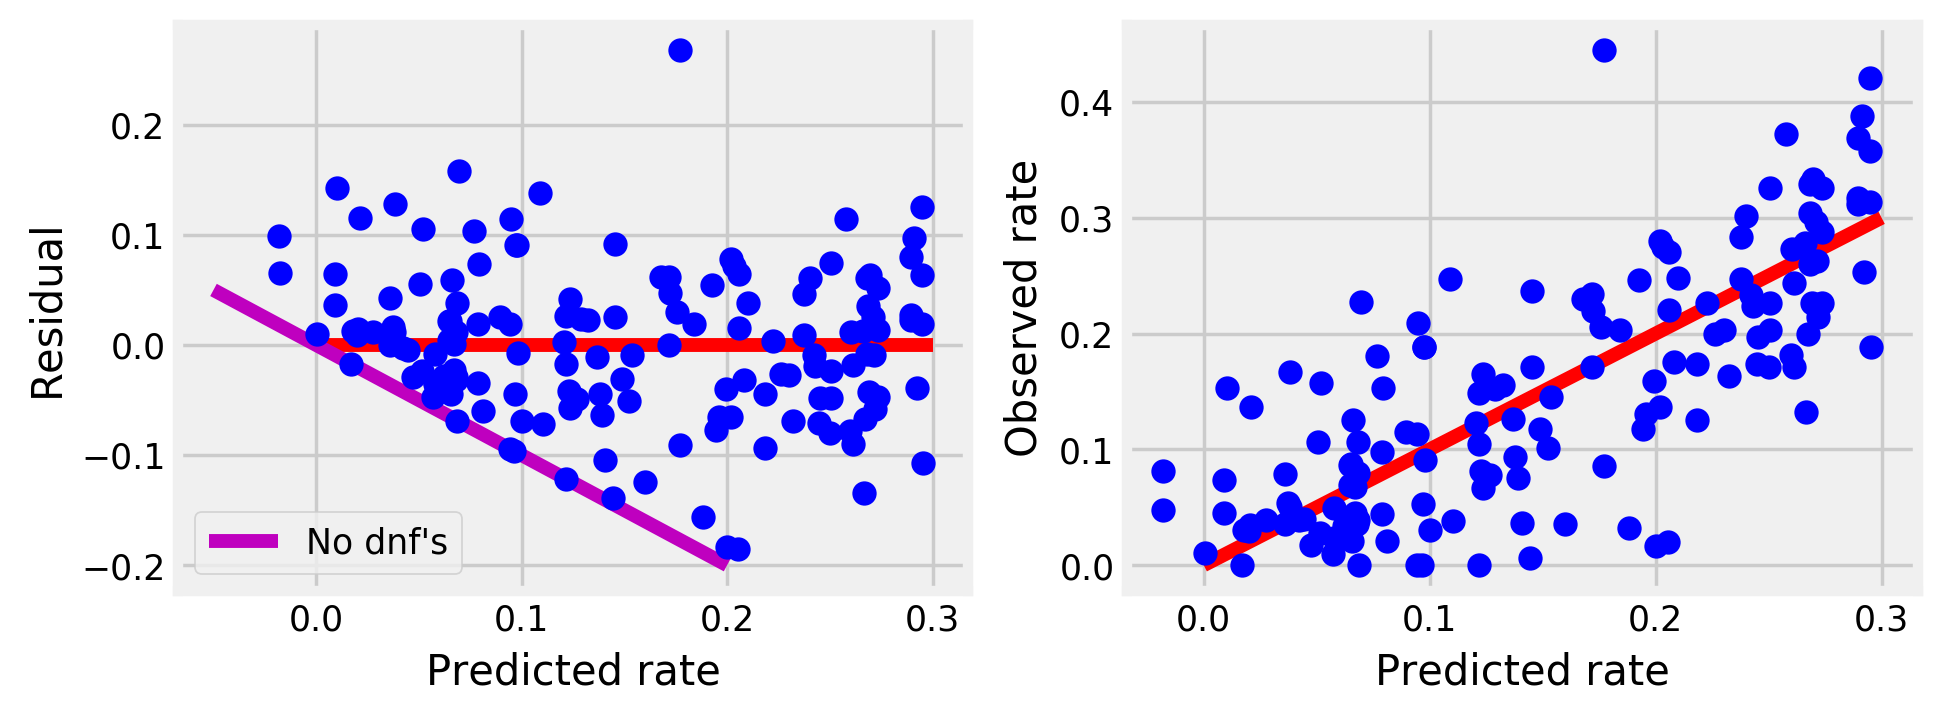

In [106]:
best_lasso.fit(X_train_scaled,y_train)
print("Training score:",best_lasso.score(X_train_scaled,y_train))
print("Testing_score:",best_lasso.score(X_test_scaled,y_test))

# Plotting residual
lasso_pred = best_lasso.predict(X_test_scaled)
resid = [true-pred for true, pred in zip(y_test, lasso_pred)]

plt.figure(dpi=250,figsize=(8,3))

plt.subplot(1,2,1)
plt.plot([0,.3],[0,0],"r")
plt.plot([-0.05,0.2],[0.05,-.2],"m", label="No dnf's")
plt.plot(lasso_pred,resid,"ob")
plt.legend(loc="lower left")
plt.xlabel("Predicted rate")
plt.ylabel("Residual")

plt.subplot(1,2,2)
plt.plot([0,.3],[0,.3],"r")
plt.plot(lasso_pred,y_test, "ob")
plt.xlabel("Predicted rate")
plt.ylabel("Observed rate");

In [143]:
def get_resid(record):
    Xi = record[features].reshape(1,-1)
    Xi_scaled = ssX.transform(Xi)
    predicted = best_lasso.predict(Xi_scaled)
    resid = record[target]-predicted
    return resid[0]

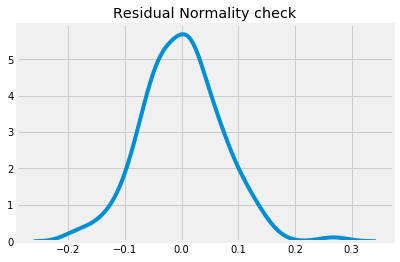

In [144]:
plt.title("Residual Normality check")
sns.kdeplot(resid);

In [139]:
test_df["resid"]=[get_resid(record) for _, record in test_df.iterrows() ]

/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/nix/store/6w1s70a6725sj8rq295v515s9xyxqq1v-python3-3.6.4-env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [141]:
resid_max = max(test_df["resid"])
test_df[test_df["resid"] == resid_max]

,dnf_rate,location,gender:ladies,event,date,finish_times,datetime,season,days_since_season_start,ski_field,...,region:FRA,region:GER,region:ITA,region:KOR,region:NEUTRAL,region:NOR,region:SE_ALPS,days^2_since_season_start,days^3_since_season_start,resid
27,0.444444,Kitzbuehel (AUT),False,Super Combined,27 January 2013,"[225.8, 227.06, 228.36, 231.32999999999998, 23...",2013-01-27,2013,92,Kitzbuehel (AUT),...,0,0,0,0,0,0,1,8464,778688,0.267517


In [142]:
max(test_df["dnf_rate"])

0.4444444444444444